In [1]:
from data_wrangler import synthetic_data_gen, feature_extractor
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline, atp_graph, losses
from data_wrangler import dataset_preparer
from data_wrangler.batcher import batcher
import os
import IPython
import matplotlib.pyplot as plt
import numpy as np

In [2]:
exchange = pd.read_csv('datasets/exchange.csv')

In [3]:
array = np.array(exchange)
array[:,0] = np.linspace(-1,1,array.shape[0])
array = array.astype("float32")

In [4]:
array[:5000, :].shape

(5000, 9)

In [5]:
exchange

,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7583,2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010/10/9 0:00,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


In [6]:
def batcher_bc(array, n_C, n_T, batch_size=32):
    t = []
    y = []
    for i in range(batch_size):
        index = int(np.random.randint(0, array.shape[0] - n_C - n_T, 1))
        t_context =  array[index:index + n_C , 0]
        t_context = np.repeat(t_context, array.shape[1] - 1)[:, np.newaxis]
        t_target = array[index + n_C:index + n_C + n_T, 0]
        t_target = np.repeat(t_target, array.shape[1] - 1)[:, np.newaxis]
        
        y_temp_context = array[index:index + n_C , 1]
        y_temp_target = array[index + n_C:index + n_C + n_T, 1]
        y_temp_all = np.concatenate([y_temp_context, y_temp_target], axis=0)
        t_all = np.concatenate([t_context, t_target], axis=0)
        for i in range(2, array.shape[1]):
            y_temp_all = np.concatenate([y_temp_all, array[index:index + n_C + n_T, i]], axis=0)

        t.append(t_all)
        y.append(y_temp_all)
    return np.array(y), np.array(t)

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor("datasets/exchange.csv") 


In [8]:
y_train.shape

(5235, 1, 1)

In [9]:
save_dir = 'weights/forecasting/exchange/multivariate'

In [15]:

run = 2
tr_step = atp_graph.build_graph()
model = atp_pipeline.atp_pipeline(multiply=8)
###### can we put the name of the model into the folder name #########?

name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
opt = tf.keras.optimizers.Adam(3e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000

In [16]:
n_C, n_T = 96, 96

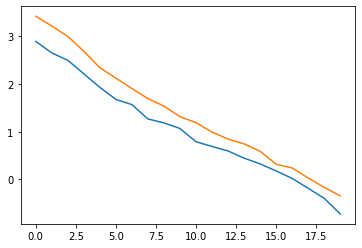

In [17]:
tr_loss = [] ; val_loss = []
n_C2 = n_C * 8
n_T2 = n_T * 8
batch_s = 32
for i in range(2000):
    x, y = batcher_bc(array[:5000, :], n_C, n_T) 
    y_re = np.concatenate([y[:, n_C2 + n_T * i:n_C2+(n_T * (i +1))] for i in range(8)], axis=-1)
    y_re = y_re.reshape(batch_s, -1, 1)
    _,_, nll_pp_tr, _ = tr_step(model, opt, x[:, :, np.newaxis], y, n_C, n_T, training=True, multiple=8, y_re=y_re)
    
    
    if (i+1) % 100 == 0:
        x, y = batcher_bc(array[5000:6000, :], n_C, n_T) 
        y_re = np.concatenate([y[:, n_C2 + n_T * i:n_C2+(n_T * (i +1))] for i in range(8)], axis=-1)
        y_re = y_re.reshape(batch_s, -1, 1)
        mu, log_sigma = model([x[:, :, np.newaxis], y, n_C, n_T, False]) 
        _, _, _, nll_pp_val, mse = losses.nll(y_re, mu, log_sigma)
        if nll_pp_val.numpy() < mini:
            ckpt.step.assign_add(1)
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            print("loss {:1.2f}".format(nll_pp_tr.numpy()))
        tr_loss.append(nll_pp_tr.numpy())
        val_loss.append(nll_pp_val.numpy())
        IPython.display.clear_output(wait=True)
        plt.plot(tr_loss)
        plt.plot(val_loss)
        plt.show()

In [22]:
mse

<tf.Tensor: shape=(), dtype=float32, numpy=9.765955e-05>

In [17]:
a = tf.constant([[5,5,5,5,5]], dtype=tf.float32)

In [18]:
a

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[5., 5., 5., 5., 5.]], dtype=float32)>

In [42]:
tf.random.categorical(a, 3)

<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[0, 2, 4]])>

In [58]:
tf.repeat([1], 20)

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)>

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>

In [2]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor(path_to_data="datasets/ETTm2.csv") 


In [3]:
from data_wrangler import batcher

In [4]:
idx_list = list(np.arange(0, x_train.shape[0] - 25, 1))
x, y, _, _ = batcher.batcher(x_train, y_train, idx_list=idx_list, window=70)


length of idx list: 48054


In [5]:
a = atp_pipeline.atp_pipeline(multiply=1)

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-05-22 13:08:13.695340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-22 13:08:13.695491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
a([x, y, 25, 25, True])

tf.Tensor(15, shape=(), dtype=int32) tf.Tensor(17, shape=(), dtype=int32)
(11,) (10,)
mask shape: (21, 21)
current_x.shape (32, 11, 1, 1)
current_y.shape (32, 11, 1, 1)
x_values.shape (32, 21, 1)
x_temp.shape (32, 11, 11, 1)


(<tf.Tensor: shape=(32, 10, 1), dtype=float32, numpy=
 array([[[-8.137888  ],
         [-9.352283  ],
         [-8.224017  ],
         [-8.188688  ],
         [-7.610757  ],
         [-6.4798527 ],
         [-6.3099003 ],
         [-8.248194  ],
         [-7.409078  ],
         [-8.542721  ]],
 
        [[-7.917127  ],
         [-7.857571  ],
         [-7.5110245 ],
         [-6.9490666 ],
         [-7.3059573 ],
         [-6.7908483 ],
         [-7.9504566 ],
         [-6.6682014 ],
         [-7.9812503 ],
         [-7.278165  ]],
 
        [[-3.9570374 ],
         [-3.0392778 ],
         [-4.3583403 ],
         [-3.1573086 ],
         [-4.437545  ],
         [-4.0602746 ],
         [-5.0663476 ],
         [-2.3821726 ],
         [-3.7942734 ],
         [-3.5647173 ]],
 
        [[-3.7544925 ],
         [ 0.91426885],
         [-0.97757816],
         [-1.4065676 ],
         [-2.0419464 ],
         [-4.241762  ],
         [-1.7011049 ],
         [-1.7022653 ],
         [-3.9136174 ],
 

In [97]:
n_C_s.

array([3], dtype=int32)

In [ ]:
        (32, 336, 432)
x_temp shape (32, 336, 432, 1)
x_current shape (32, 336, 1, 1)

In [ ]:
x_mask_float_repeat.shape (32, 16, 25)
current_x.shape (32, 6, 1, 1)
x_temp.shape (32, 16, 15, 1)

In [7]:
from data_wrangler import feature_extractor

In [8]:
f = feature_extractor.feature_wrapper()

In [9]:
x1, y1, n_C, n_T, idx_c, idx_t = f.subsample(x, y, 20, 10)


tf.Tensor(6, shape=(), dtype=int32) tf.Tensor(3, shape=(), dtype=int32)
(4,) (1,)


In [10]:
x1.shape

TensorShape([32, 5, 1])

In [11]:
y1.shape

TensorShape([32, 5, 1])

In [12]:
n_T

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [14]:
idx_t

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 5, 6])>

In [15]:
idx_c

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 2, 3])>

In [29]:
np.sort(os.listdir('/Users/omernivron/Downloads/Taylorformer_docs/val_loss_gp/' + folder  + '/' + f))

array(['validation_losses_iteration_0.npy',
       'validation_losses_iteration_1.npy',
       'validation_losses_iteration_2.npy',
       'validation_losses_iteration_3.npy',
       'validation_losses_iteration_4.npy'], dtype='<U33')

In [45]:
# plt.style.use('seaborn-whitegrid')
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

Taylorformer
anp
np
tnp
Taylorformer
anp
np
tnp
Taylorformer
anp
np
tnp


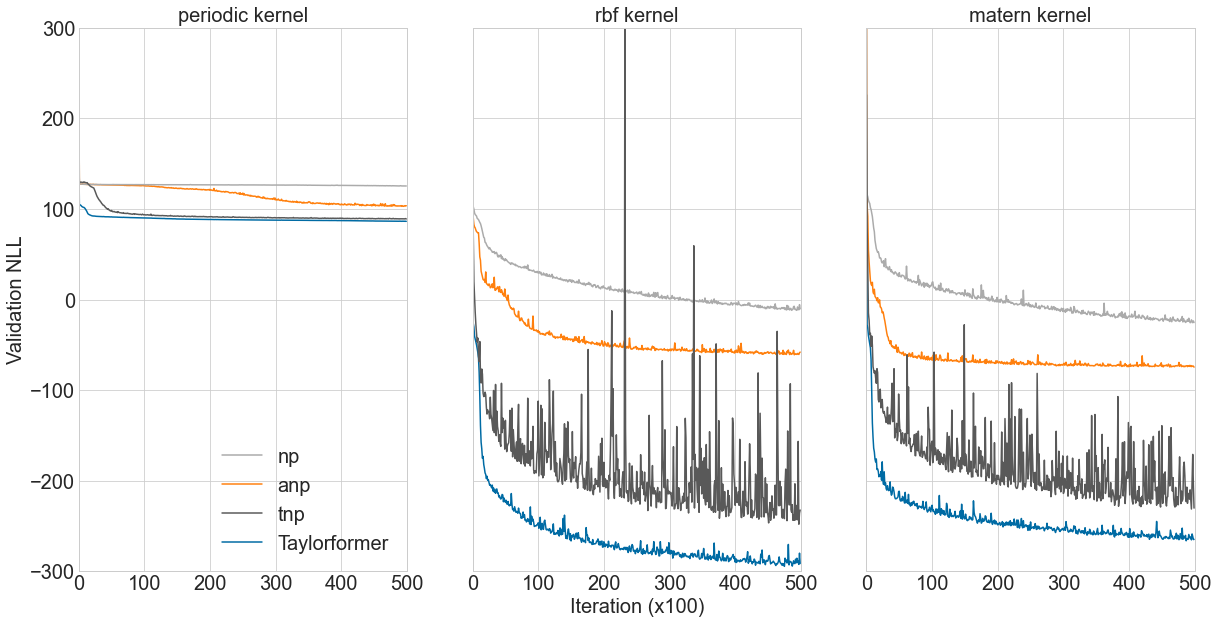

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
folders = os.listdir('/Users/omernivron/Downloads/Taylorformer_docs/val_loss_gp')
folders.remove('.DS_Store')
for ix, folder in enumerate(folders):
   ## not including .DS_Store
    # print(folder)
    if folder.startswith('.DS'):
        pass
    else:
        for f in os.listdir('/Users/omernivron/Downloads/Taylorformer_docs/val_loss_gp/' + folder):
            # print(f)
            if f.startswith('.DS'):
                pass
            else:
                arr_t = np.load('/Users/omernivron/Downloads/Taylorformer_docs/val_loss_gp/' + folder + '/' + f +  '/' + 'validation_losses_iteration_0.npy', allow_pickle=True)
                if f.split('_')[0] == 'atp':
                    f = 'Taylorformer'  
                print(f)
                ax[ix].plot(arr_t, label=f.split('_')[0])
                ax[ix].set_title(folder + ' kernel', fontsize=24)
                ax[ix].set_ylim(-300, 300)
                ax[ix].set_xlim(0, 500)
                ax[ix].tick_params(axis='both', which='major', labelsize=20)
                if ix==0:
                    ax[ix].set_ylabel('Validation NLL', fontsize=24)
   
                    
                if ix==1:
                    ax[ix].set_xlabel('Iteration (x100)', fontsize=24)
                if ix >=1:
                    ax[ix].set_yticklabels([])
                
labels, handles = ax[ix].get_legend_handles_labels()
handles = [handles[2], handles[1], handles[3],handles[0]]
labels = [labels[2], labels[1], labels[3],labels[0]]
ax[0].legend(labels, handles, fontsize=22, loc='lower right')
plt.savefig('kernel_comparison.pdf')
plt.show()